In [65]:
from tqdm import tqdm
import smiles_generate as sg
import visualize as vis
import importlib
import utils
import subprocess
import data_process as dp
import pandas as pd
import numpy as np
from rdkit import Chem

importlib.reload(vis)
importlib.reload(sg)
importlib.reload(utils)
importlib.reload(dp)

<module 'data_process' from '/home/k0335/k033513/electret_cal/data_process.py'>

## FFKM 与 基底的反应

**生成了smiles以及name的list**

In [32]:
name_list = []
smiles_list = []
base = 'C=CCN1C(=O)N(C(=O)N(C1=O)CC=C)CC=C'
for direction in ['L','R']:
    for c in [0]:
        # for m in [1,2,3]:
        for m in [1,2,3]:
            # for n in [0,2,4,6]:
            for n in [0]:
                FFKM,connection_point = sg.FFKM_builder(m = m,n = n, c=c,connection_direction=direction)
                crossed_mol = sg.crosslink_reaction(base,FFKM,connection_point)
                name_list.append(f'taic{direction}M{m}N{n}C{c}')
                smiles_list.append(crossed_mol)

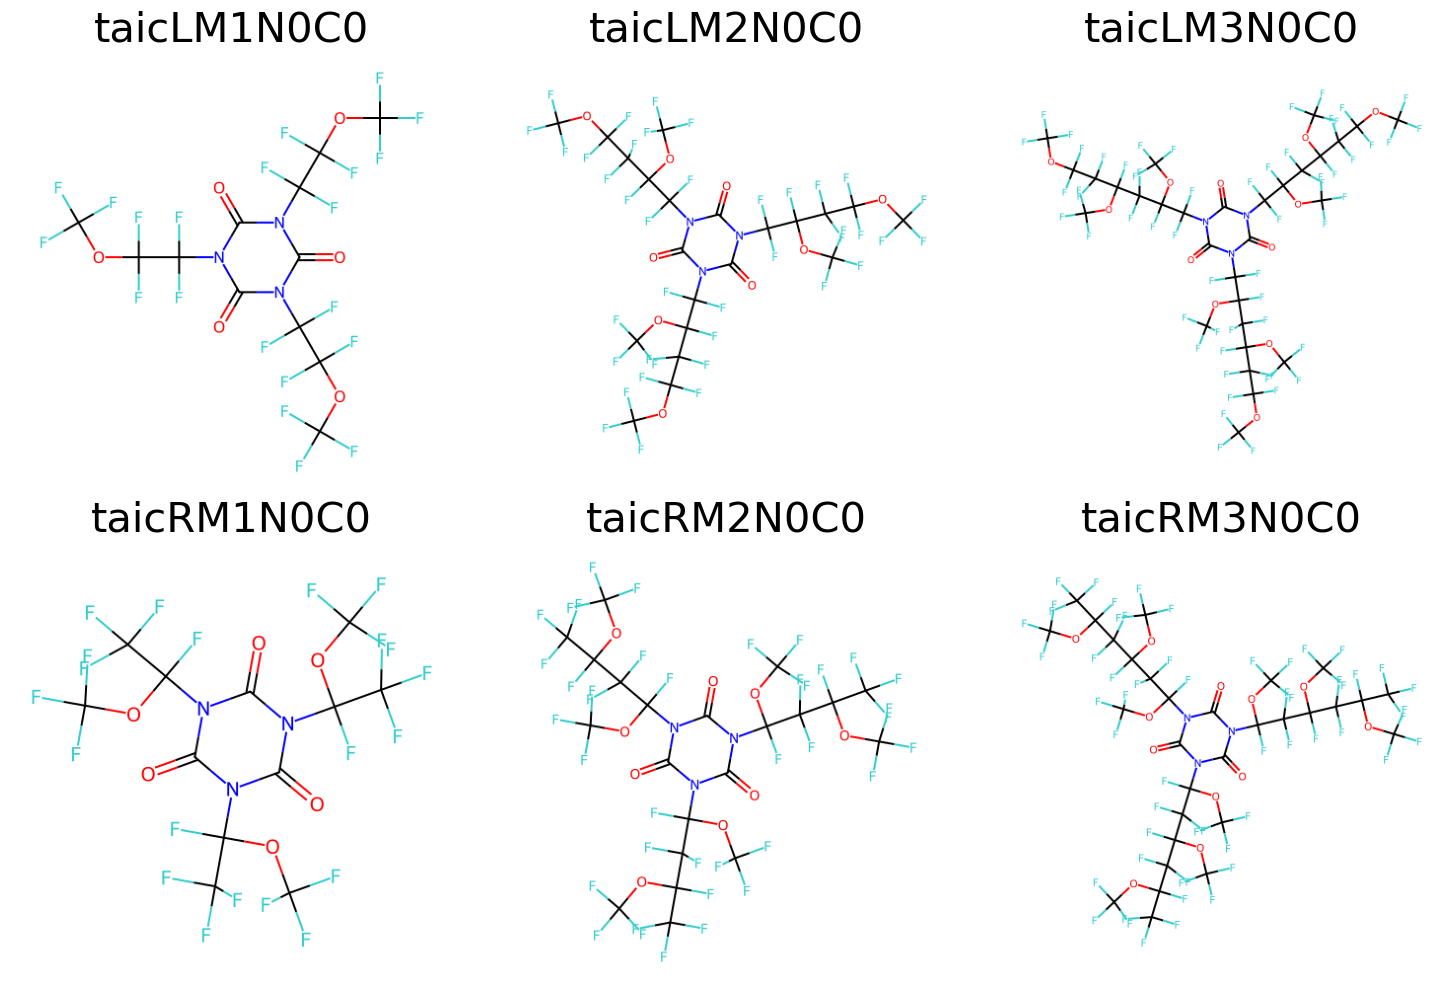

In [24]:
vis.multi_mol_plot(smiles_list = smiles_list,name_list = name_list,cols=3,save_name='taic_crosslink_test1.pdf')

# 高斯计算

**计算方法，计算基组，参数设置**

In [14]:
method = 'CAM-B3LYP'
basis = '6-31G(d,p)'
PCM = 'True'
EPS = 4.9
iteration = 1
debug = False

**根据smiles表达式生成分子的xyz文件**

In [28]:
for i in tqdm(range(len(name_list))):
    for j in range(iteration):
        try:
            utils.smile2xyz(name_list[i]+str(j)+'_0.xyz',smiles_list[i],randomSeed=None)
        except:
            print(name_list[i]+str(j))

100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


**进行高斯计算**

In [29]:
import gaussian_cal
import os

G0 = gaussian_cal.GaussianCal(method=method,basis=basis,charge='neu',wfn=True,debug=debug,PCM=PCM,EPS=EPS)
G1 = gaussian_cal.GaussianCal(method=method,basis=basis,charge='pos',wfn=True,debug=debug,PCM=PCM,EPS=EPS)

for i in range(len(name_list)):
    for j in range(iteration):
        if os.path.exists(f"{name_list[i]}{j}"):
            if debug:
                while utils.i8cpu_running():
                    time.sleep(60)
            G0.Run(f"{name_list[i]}{j}_0.xyz")
            if debug:
                while utils.i8cpu_running():
                    time.sleep(60)
            G1.Run(f"{name_list[i]}{j}_0.xyz")

Submitted batch job 1822417
Submitted batch job 1822418
Submitted batch job 1822419
Submitted batch job 1822420
Submitted batch job 1822421
Submitted batch job 1822422
Submitted batch job 1822423
Submitted batch job 1822424


# 数据分析

In [5]:
importlib.reload(dp)

<module 'data_process' from '/home/k0335/k033513/electret_cal/data_process.py'>

In [33]:
IP_list = []
for i in range(iteration):
    IP_list.append([])
    for j in tqdm(range(len(name_list))):
        IP_list[i].append(dp.charge_calculation(name_list[j] + str(i),"IP"))
df_IP = pd.DataFrame(IP_list, columns = name_list)
df_IP.T

100%|██████████| 6/6 [00:00<00:00, 18.41it/s]


In [2]:
import screen as sc
importlib.reload(sc)

<module 'screen' from '/home/k0335/k033513/electret_cal/screen.py'>

In [16]:
Pubchem = pd.read_csv("/home/k0335/k033513/electret_cal/similarity.csv")

In [82]:
count = 0
pubchem_ffkm_smiles = []
pubchem_ffkm_name = []
FFKM,connection_point = sg.FFKM_builder(m=1,n=0,c=3,connection_direction='L')

for i in tqdm(range(len(Pubchem['canonicalsmiles']))):
    base = Pubchem['canonicalsmiles'][i]
    ssr = Chem.GetSymmSSSR(Chem.MolFromSmiles(base))
    num_ring = len(ssr)
    if num_ring > 0 and '+' not in base and '-' not in base and '.' not in base:
        smiles = sg.crosslink_reaction(base,FFKM,connection_point)
        if '.' not in smiles:
            count += 1
            pubchem_ffkm_smiles.append(smiles)
            pubchem_ffkm_name.append('A' +str(Pubchem[' cid'][i]))


 78%|███████▊  | 2989/3845 [00:01<00:00, 1665.87it/s][17:56:35] WARNING: not removing hydrogen atom without neighbors
[17:56:35] WARNING: not removing hydrogen atom without neighbors
 83%|████████▎ | 3182/3845 [00:01<00:00, 1739.26it/s][17:56:35] WARNING: not removing hydrogen atom without neighbors
[17:56:35] WARNING: not removing hydrogen atom without neighbors
[17:56:35] WARNING: not removing hydrogen atom without neighbors
[17:56:35] WARNING: not removing hydrogen atom without neighbors
[17:56:35] WARNING: not removing hydrogen atom without neighbors
[17:56:35] WARNING: not removing hydrogen atom without neighbors
 88%|████████▊ | 3390/3845 [00:01<00:00, 1838.01it/s][17:56:35] WARNING: not removing hydrogen atom without neighbors
[17:56:35] WARNING: not removing hydrogen atom without neighbors
[17:56:35] WARNING: not removing hydrogen atom without neighbors
[17:56:35] WARNING: not removing hydrogen atom without neighbors
[17:56:35] WARNING: not removing hydrogen atom without neighb

In [83]:
len(pubchem_ffkm_smiles)

2335

In [77]:
pubchem_ffkm_smiles

['O=c1n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c(=O)n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c(=O)n1CCCC(F)(F)C(F)(F)OC(F)(F)F',
 'O=c1[nH]c(=O)n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c(=O)n1CCCC(F)(F)C(F)(F)OC(F)(F)F',
 'CCCC(F)(F)C(F)(F)OC(F)(F)F.CCCC(F)(F)C(F)(F)OC(F)(F)F.CCCC(F)(F)C(F)(F)OC(F)(F)F.O=c1n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c(=O)n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c(=O)n1CCCC(F)(F)C(F)(F)OC(F)(F)F',
 'CCCn1c(=O)n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c(=O)n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c1=O',
 'Cc1cn(CCCC(F)(F)C(F)(F)OC(F)(F)F)c(=O)n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c1=O',
 'CCCC(C)C1(CC)C(=O)N(CCCC(F)(F)C(F)(F)OC(F)(F)F)C(=O)N(CCCC(F)(F)C(F)(F)OC(F)(F)F)C1=O',
 'Cc1cc(=O)n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c(=O)n1CCCC(F)(F)C(F)(F)OC(F)(F)F',
 'CCC1(CCC(C)C)C(=O)N(CCCC(F)(F)C(F)(F)OC(F)(F)F)C(=O)N(CCCC(F)(F)C(F)(F)OC(F)(F)F)C1=O',
 'Cn1cnc2c1c(=O)n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c(=O)n2CCCC(F)(F)C(F)(F)OC(F)(F)F',
 'Cn1nc(OCC(=O)N2CCN(c3ccccc3)CC2)cc1-c1nc2c([nH]1)c(=O)n(CCCC(F)(F)C(F)(F)OC(F)(F)F)c(=O)n2CCCC(F)(F)C(F)(F)OC(F)(F)F',
 'O=C1C(CCCC(